# Modules

In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
from lifelines import  KaplanMeierFitter
from lifelines import  NelsonAalenFitter
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Fonctions

In [2]:
def customize_corr(df: pd.DataFrame) :
    
    """ 
      Customize correlation matrix visually  
      
    Arguments:
        df - dataframe with features
    
    Returns: 
    """
    
    # modules
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(16, 10))
    
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr()))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='magma')
    heatmap.set_title('Lower Correlation Matrix', fontdict={'fontsize':18}, pad=16)

In [3]:
def corr_features(df: pd.DataFrame, threshold: float) :
    
    """  
      A function to suggest features that are highly correlated (one among two). 
            
      Arguments:
          df - dataframe with features
          treshold - lower limit to consider that features are not highly correlated
    
    Returns:  
        List of features to drop
    """
    
    correlation = df.corr().abs()
    upper = correlation .where(np.triu(np.ones(correlation .shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

In [4]:
def discritiser(x,p,d):
    """
    A function for pareto analyis
    
    Arguments:
    d- dataframe with rfm information
    x- a number (float)
    pq -quantitative columns
        
    Returns:
      an integeer betwen 1 and 4
   """
    if x <= d[p][0.25]:
        return "1"
    elif x <= d[p][0.50]:
        return "2"
    elif x <= d[p][0.75]: 
        return "3"
    else:
        return "4"

# Analye exploratoire

In [5]:
df = pd.read_pickle('intermed/table_fo_lifetime.sav').drop('T_month', axis=1)
df.head()

,customer_Id,Gender,category_Bags,category_Books,category_Clothing,category_Electronics,category_Footwear,category_Home and kitchen,frequency,recency,monetary_value,RFM_Score,age,attrition,life,age_1,age_2,age_3,age_4
0,266783,1,0,1,1,0,1,0,3.0,516.0,1037.963333,5,47,0,29,0,0,0,1
1,266784,0,0,1,0,1,0,0,2.0,103.0,707.200000,4,30,1,9,1,0,0,0
2,266785,0,1,1,0,0,1,1,6.0,870.0,3588.487500,12,36,0,36,0,1,0,0
3,266788,0,1,1,0,0,1,0,3.0,611.0,1574.993333,6,49,0,33,0,0,0,1
4,266794,0,1,1,1,1,1,0,9.0,1062.0,2839.113333,11,50,0,36,0,0,0,1


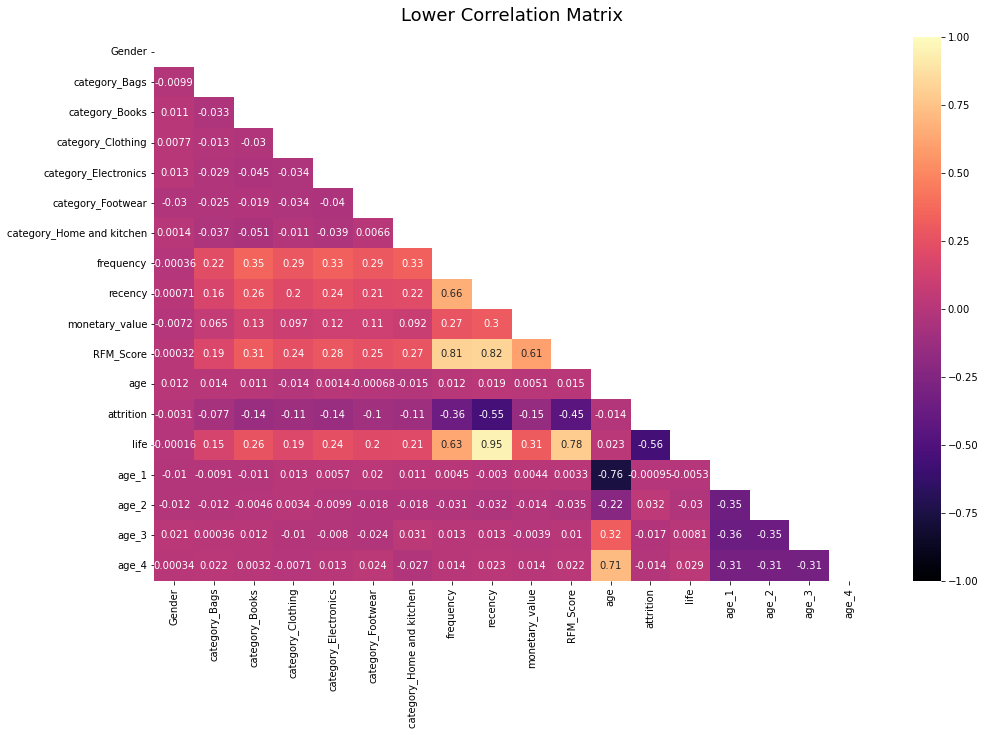

In [6]:
customize_corr(df.drop('customer_Id',axis=1))

In [7]:
corr_features(df, 0.9)

['life']

# Estimation non paramétrique de la function de survie

## Estimation de Kaplan-Meier

Nous ne disposons pas de la fonction de survie théorique de la clientèle.

Nous allons l'estimer à partir des données :  l'estimateur non paramétrique de Kaplan-Meier

$$S(t)=\prod_{\substack{i= t_i \le t}}\frac{n_i-d_i}{n_i}$$ 

$n_i$ = population à risque au moment juste avant le temps $t_i$

$d_i$ = nombre d'événements survenus à l'instant $ t_i $

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df.life, event_observed=df.attrition, label="KM estimate")

<lifelines.KaplanMeierFitter:"KM estimate", fitted with 5506 total observations, 4213 right-censored observations>

Les clients  qui n'ont pas été soumis à l'événement de décès d'attrition sont étiquetés comme censurés à droite,

c'est-à-dire que nous n'avons pas (ou ne pouvons pas) voir le reste de leur histoire de vie en raison de certaines circonstances externes (ici la fin de l'expérimenttion s'arrete en  Fevrier 2014)

Text(0.5, 1.0, 'Fonctions de survie de la clientèles')

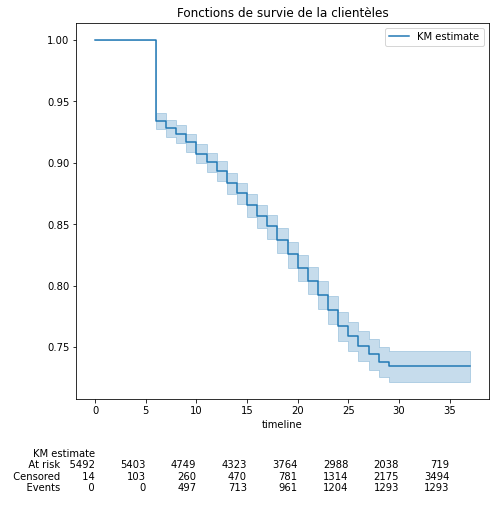

In [9]:
kmf.plot_survival_function(figsize=(7, 7), at_risk_counts=True)
plt.title('Fonctions de survie de la clientèles')

L'axe des ordonnées représente la probabilité qu'un client soit notre client après t mois , où t mois se lit en abscisses.

In [10]:
kmf.median_survival_time_

inf

Nos clients ont 50 % de chances de partir  après 23 mois ou moins !

In [11]:
from lifelines.utils import median_survival_times
median_survival_times(kmf.confidence_interval_)

,KM estimate_lower_0.95,KM estimate_upper_0.95
0.5,inf,inf


Text(0.5, 1.0, 'Fonctions de survie selon le sexe')

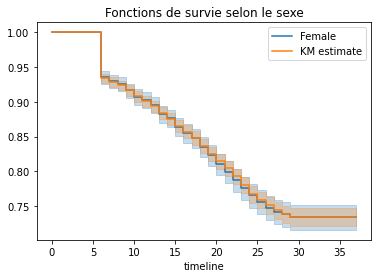

In [12]:
ax = plt.subplot(111)

kmf_gender = KaplanMeierFitter()



kmf_gender.fit(
              durations = df[df['Gender'] == 0]['life'], 
              event_observed=df[df['Gender'] == 0]['attrition'],
              label='Female'
               )
kmf_gender.plot_survival_function(ax=ax)

kmf_gender.fit(
              durations = df[df['Gender'] == 1]['life'], 
              event_observed=df[df['Gender'] == 1]['attrition'],
              label='MALE'
               )

kmf.plot_survival_function(ax=ax)

plt.title('Fonctions de survie selon le sexe')

Plus de 100 % de risque de survie les 6 premiers mois

Environs 80% de risque de survie sur les 22 premiers mois

Il n y a pas de difference significrative selon le genre.

Estimation de Nelson Aalen

Néanmoins, l'expérience à montrer l'approche KM ne permet pas de bien estimer les fonctions de risques( hazard function) et  fonction cumulées de risque

$$\tilde H(t)=\sum_{\substack{i= t_i < t}}\frac{d_i}{n_i}$$ 

$n_i$ = population à risque au moment juste avant le temps $t_i$

$d_i$ = nombre d'événements survenus à l'instant $ t_i $

Cet estimateur présente des avantages par rapport à l'estimateur de Kaplan-Meier.

L'estimateur donne le nombre d'événements attendu correct.
Il existe une multitude de théories asymptotiques basées sur l'estimateur d'Altschuler-Nelson.

$$S(t) =exp(\tilde H(t) )$$ 


<AxesSubplot:xlabel='timeline'>

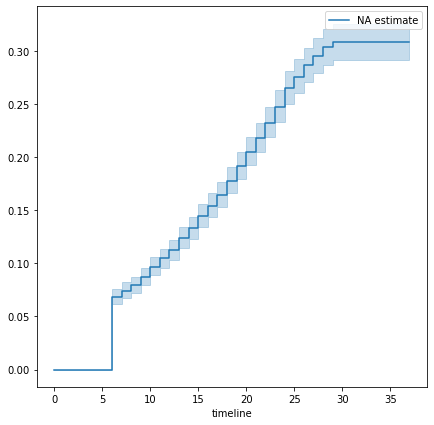

In [13]:
naf = NelsonAalenFitter()
naf.fit(durations=df.life, event_observed=df.attrition, label="NA estimate")
naf.plot_cumulative_hazard(figsize=(7,7))

L'interprétation de la fonction de risque cumulé peut être difficile - ce n'est pas la façon dont nous interprétons habituellement les fonctions. D'autre part, la plupart des analyses de survie sont effectuées à l'aide de la fonction de risque cumulé, il est donc recommandé de la comprendre.

Néanmoins nous pouvons déduire  la fonction de risque qui est plus interpretable. Mais il y a un hic. La déduction implique un lissage du noyau (pour lisser les différences de la fonction de risque cumulé), et cela nous oblige à spécifier un paramètre de bande passante qui contrôle de bandwith.

<AxesSubplot:>

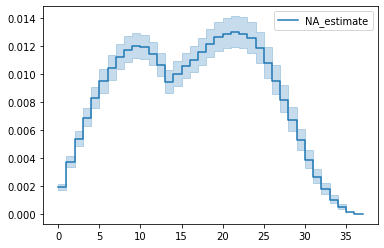

In [14]:
naf = NelsonAalenFitter()
naf.fit(durations=df.life, event_observed=df.attrition)
naf.plot_hazard(bandwidth=7)

high probability of attrition after 1 year ou 2 years (seasonality?????)

In [15]:
df[df.columns[df.columns.str.startswith('age_')]].sum()

age_1    1452
age_2    1407
age_3    1469
age_4    1178
dtype: int64

La classe de réference sera alors la classe 3 car c'est la modalité la plus répresentée.

# Estimation  paramétrique

## formalisation  du modèle de Cox

$$ h(t|x)=b_0(t)\exp( \sum_{i=1}^{n}b_i(x_i-\overline{x_i})) $$ 


$ h(t|x) $ :   hazard functions

$ b_0(t) $ :    baseline hazard, no assumption about the shape of it
 
$ b_i $  :      Regression parameters

$ b_i(x_i-\overline{x_i}) $ :  log-partial hazard 

$ exp( \sum_{i=1}^{n}b_i(x_i-\overline{x_i})$ : is partial hazard

In [16]:
## Separtion des données

In [17]:
df = df.drop('age_3', axis=1) # remove one feature to avoid colinearity
train, test = train_test_split(df, test_size=0.2, stratify=df.attrition)

## Estimations

In [18]:
### Premier modèle

In [19]:
cph = CoxPHFitter()
cph.fit(df.drop('customer_Id',axis=1), 'life',event_col='attrition') 
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5506 total observations, 4213 right-censored observations>
             duration col = 'life'
                event col = 'attrition'
      baseline estimation = breslow
   number of observations = 5506
number of events observed = 1293
   partial log-likelihood = -8341.50
         time fit was run = 2022-02-09 01:25:05 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
Gender                     -0.04       0.97       0.06            -0.15             0.07                 0.86                 1.08
category_Bags               0.17       1.19       0.08             0.01             0.33                 1.01                 1.39
category_Books             -0.07       0.93       0.08            -0.22             0.08                 0.80                 1.09
category_Clothing           0.07       1.07       0.08            -0.08             0.23                 0.92                 1.26
category_Electronics       -0.01       0.99       0.08            -0.16             0.15                 0.85                 1.16
category_Footwear           0.08       1.08       0.08            -0.07             0.24                 0.93                 1.26
category_Home and kitchen   0.08       1.08       0.08            -0.08             0.23                 0.93                 1.25
frequency                  -0.04       0.96       0.05            -0.15             0.07                 0.86                 1.07
recency                    -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
monetary_value             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
RFM_Score                   0.03       1.03       0.05            -0.06             0.12                 0.95                 1.13
age                        -0.02       0.98       0.02            -0.05             0.02                 0.95                 1.02
age_1                      -0.14       0.87       0.21            -0.56             0.27                 0.57                 1.31
age_2                       0.03       1.03       0.12            -0.21             0.27                 0.81                 1.30
age_4                       0.09       1.09       0.13            -0.16             0.33                 0.85                 1.40

                               z      p   -log2(p)
covariate                                         
Gender                     -0.63   0.53       0.91
category_Bags               2.08   0.04       4.72
category_Books             -0.90   0.37       1.43
category_Clothing           0.91   0.36       1.47
category_Electronics       -0.08   0.94       0.09
category_Footwear           1.02   0.31       1.71
category_Home and kitchen   0.98   0.33       1.61
frequency                  -0.73   0.47       1.10
recency                   -40.96 <0.005        inf
monetary_value             -0.66   0.51       0.97
RFM_Score                   0.73   0.47       1.10
age                        -0.92   0.36       1.48
age_1                      -0.67   0.50       0.99
age_2                       0.22   0.82       0.28
age_4                       0.69   0.49       1.03
---
Concordance = 0.97
Partial AIC = 16713.00
log-likelihood ratio test = 4940.64 on 15 df
-log2(p) of ll-ratio test = inf

### Visulation des valeurs des paramètres estimés

<AxesSubplot:xlabel='log(HR) (95% CI)'>

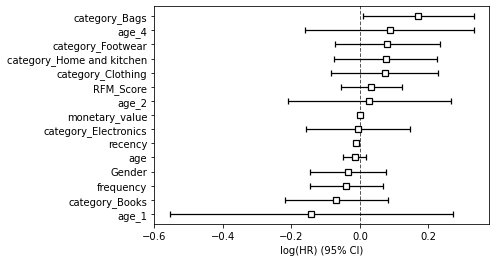

In [20]:
cph.plot()

Hazard ratio (HR) = $exp(b_i)$ ==> $b_i = log(HR)$, where coef is the weight corresponding to the feature. 

If HR = 1 for a feature, then it has no effect. 

If HR > 1, decreases the hazard: improves the survival.

## Recherche du modèle parcimonieux

Supprimer les variables qui n'ont pas significatifs sur la probabilité d'attrition.

Estimer le modèle avec les variables restantes.

In [21]:
df_stats = cph.summary
features_valuable = list(df_stats[df_stats['exp(coef)'].values > 1.02].index) + list(df_stats[df_stats['exp(coef)'].values < 0.98].index)
train_2= df[features_valuable+['life','attrition']]

In [22]:
cph = CoxPHFitter(penalizer=0)                         # THE OPTIMALE value is 0 (test with array of value)
cph.fit(train_2, 'life',event_col='attrition') 
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5506 total observations, 4213 right-censored observations>
             duration col = 'life'
                event col = 'attrition'
      baseline estimation = breslow
   number of observations = 5506
number of events observed = 1293
   partial log-likelihood = -9613.14
         time fit was run = 2022-02-09 01:25:06 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
category_Bags               0.05       1.05       0.07            -0.09             0.20                 0.91                 1.22
category_Clothing          -0.08       0.92       0.07            -0.21             0.06                 0.81                 1.06
category_Footwear          -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.12
category_Home and kitchen   0.00       1.00       0.06            -0.12             0.13                 0.89                 1.14
RFM_Score                  -0.61       0.54       0.02            -0.66            -0.56                 0.52                 0.57
age_2                       0.05       1.05       0.08            -0.10             0.20                 0.90                 1.22
age_4                      -0.03       0.97       0.08            -0.20             0.13                 0.82                 1.14
Gender                      0.01       1.01       0.06            -0.10             0.12                 0.90                 1.12
category_Books             -0.04       0.96       0.06            -0.16             0.09                 0.85                 1.09
frequency                  -0.21       0.81       0.04            -0.29            -0.12                 0.75                 0.88
age_1                       0.04       1.04       0.08            -0.12             0.19                 0.89                 1.21

                               z      p   -log2(p)
covariate                                         
category_Bags               0.69   0.49       1.03
category_Clothing          -1.13   0.26       1.96
category_Footwear          -0.28   0.78       0.36
category_Home and kitchen   0.07   0.94       0.09
RFM_Score                 -25.70 <0.005     481.44
age_2                       0.63   0.53       0.91
age_4                      -0.41   0.68       0.56
Gender                      0.12   0.91       0.14
category_Books             -0.57   0.57       0.82
frequency                  -4.89 <0.005      19.89
age_1                       0.47   0.64       0.64
---
Concordance = 0.87
Partial AIC = 19248.29
log-likelihood ratio test = 2397.35 on 11 df
-log2(p) of ll-ratio test = inf

In [23]:
df_stats

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Gender,-0.035156,0.965455,0.056184,-0.145274,0.074962,0.864785,1.077843,-0.625732,0.531491,0.911884
category_Bags,0.171068,1.186572,0.082408,0.009551,0.332586,1.009597,1.394570,2.075861,0.037907,4.721399
category_Books,-0.069059,0.933271,0.077122,-0.220215,0.082096,0.802346,1.085560,-0.895463,0.370540,1.432299
category_Clothing,0.072151,1.074818,0.079148,-0.082976,0.227278,0.920373,1.255179,0.911597,0.361981,1.466015
category_Electronics,-0.005837,0.994180,0.077362,-0.157464,0.145789,0.854308,1.156952,-0.075457,0.939851,0.089496
category_Footwear,0.080553,1.083886,0.078808,-0.073907,0.235013,0.928758,1.264925,1.022146,0.306712,1.705045
category_Home and kitchen,0.075256,1.078160,0.076847,-0.075361,0.225872,0.927409,1.253416,0.979297,0.327433,1.610727
frequency,-0.039729,0.961050,0.054737,-0.147011,0.067553,0.863284,1.069887,-0.725822,0.467948,1.095581
recency,-0.011653,0.988415,0.000285,-0.012210,-0.011095,0.987864,0.988966,-40.958343,0.000000,inf


## Verififcation des hypothèses 

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5506 total observations, 4213 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic      p  -log2(p)
Gender                    km              0.03   0.85      0.23
                          rank            0.00   0.97      0.04
RFM_Score                 km              0.88   0.35      1.52
                          rank            1.12   0.29      1.79
age_1                     km              3.57   0.06      4.09
                          rank            3.45   0.06      3.99
age_2                     km              0.33   0.57      0.82
                          rank            0.43   0.51      0.97
age_4                     km              0.82   0.37      1.45
                          rank            0.57   0.45      1.15
category_Bags             km              0.20   0.66      0.60
                          rank            0.43   0.51      0.97
category_Books            km              0.01   0.92      0.12
                          rank            0.08   0.78      0.37
category_Clothing         km              0.00   0.95      0.07
                          rank            0.05   0.82      0.28
category_Footwear         km              1.65   0.20      2.33
                          rank            2.71   0.10      3.32
category_Home and kitchen km              4.98   0.03      5.29
                          rank            4.84   0.03      5.16
frequency                 km            125.13 <0.005     94.08
                          rank          131.36 <0.005     98.61



1. Variable 'frequency' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'frequency' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'frequency' using pd.cut, and then specify it in
`strata=['frequency', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>]]

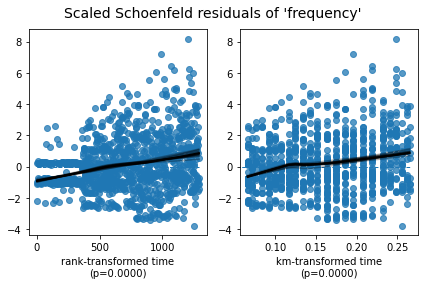

In [24]:
cph.check_assumptions(train_2, p_value_threshold=0.01, show_plots=True)

## Prédictions

In [25]:
#predict and transpose output
temp=cph.predict_survival_function(train.set_index('customer_Id'),conditional_after=train.life).T
#give friendly name to the news columns
temp.columns=['month'+  str(i) for i in range(1,temp.shape[1]+1)]

In [26]:
df_wide = pd.merge(round(temp,2), train[['life','attrition',	'customer_Id']].set_index('customer_Id'),left_index=True, right_index=True).reset_index()

In [27]:
df_wide 

,index,month1,month2,month3,month4,month5,month6,month7,month8,month9,...,month31,month32,month33,month34,month35,month36,month37,month38,life,attrition
0,270281,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,34,0
1,270022,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,29,1
2,272350,1.0,0.91,0.85,0.78,0.69,0.61,0.53,0.46,0.40,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,9,1
3,271029,1.0,0.99,0.97,0.97,0.97,0.97,0.97,0.97,0.97,...,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,26,0
4,270365,1.0,0.99,0.97,0.95,0.93,0.91,0.89,0.87,0.84,...,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4399,267408,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,35,0
4400,272796,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,36,0
4401,273328,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,35,0
4402,268992,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,37,0


In [28]:
df_long=pd.melt( 
                df_wide, 
                id_vars=['index','life','attrition'], 
                value_vars=temp.columns[temp.columns.str.startswith('month')]
               ).\
               rename(columns={'variable':'month'})
df_long    

,index,life,attrition,month,value
0,270281,34,0,month1,1.0
1,270022,29,1,month1,1.0
2,272350,9,1,month1,1.0
3,271029,26,0,month1,1.0
4,270365,16,0,month1,1.0
...,...,...,...,...,...
167347,267408,35,0,month38,1.0
167348,272796,36,0,month38,1.0
167349,273328,35,0,month38,1.0
167350,268992,37,0,month38,1.0


In [29]:
df_long['month']=df_long['month'].str.replace('month','').astype(int)
df_long=df_long.set_index('index')
df_long

,life,attrition,month,value
index,,,,
270281,34,0,1,1.0
270022,29,1,1,1.0
272350,9,1,1,1.0
271029,26,0,1,1.0
270365,16,0,1,1.0
...,...,...,...,...
267408,35,0,38,1.0
272796,36,0,38,1.0
273328,35,0,38,1.0


In [30]:
parameters = np.arange(0,1.01,0.1)

def derive_predict_attri(parameter, dfg):
        return pd.DataFrame(np.where(df_long.value<=parameter  , 1 , 0), df_long.index)

In [31]:
#comprehensive list of dataframe
result = [derive_predict_attri(parameter, df_long) for  parameter in parameters]
#concatenate dataframe horizontally
temp=pd.concat(result,axis=1)
# easy to understand names for columns
temp.columns=['params_'+ str(round(parameter,2)) for parameter in  parameters]
# aggregation output in order to derive lifetime estimate
temp.groupby('index').sum()

,params_0.0,params_0.1,params_0.2,params_0.3,params_0.4,params_0.5,params_0.6,params_0.7,params_0.8,params_0.9,params_1.0
index,,,,,,,,,,,
266784,0,0,19,22,24,26,28,30,32,35,38
266785,0,0,0,0,0,0,0,0,0,0,38
266788,0,0,0,0,0,0,0,0,0,0,38
266794,0,0,0,0,0,0,0,0,0,0,38
266799,0,0,0,0,0,0,0,0,0,34,38
...,...,...,...,...,...,...,...,...,...,...,...
275257,0,0,0,0,0,0,0,0,0,0,38
275261,0,0,0,0,0,0,0,0,0,0,38
275262,0,0,0,0,0,0,0,26,29,33,38


In [32]:
temp=pd.merge(
        temp.groupby('index').sum(), # df with lifetime estimate
        df_wide.set_index('index'),   # predictions wide data
        left_index=True, 
        right_index=True
        ).\
     filter(regex='^((?!month).)*$') # remove columns thar contains month in the output
temp

,params_0.0,params_0.1,params_0.2,params_0.3,params_0.4,params_0.5,params_0.6,params_0.7,params_0.8,params_0.9,params_1.0,life,attrition
index,,,,,,,,,,,,,
266784,0,0,19,22,24,26,28,30,32,35,38,9,1
266785,0,0,0,0,0,0,0,0,0,0,38,36,0
266788,0,0,0,0,0,0,0,0,0,0,38,33,0
266794,0,0,0,0,0,0,0,0,0,0,38,36,0
266799,0,0,0,0,0,0,0,0,0,34,38,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275257,0,0,0,0,0,0,0,0,0,0,38,27,0
275261,0,0,0,0,0,0,0,0,0,0,38,29,0
275262,0,0,0,0,0,0,0,26,29,33,38,13,1


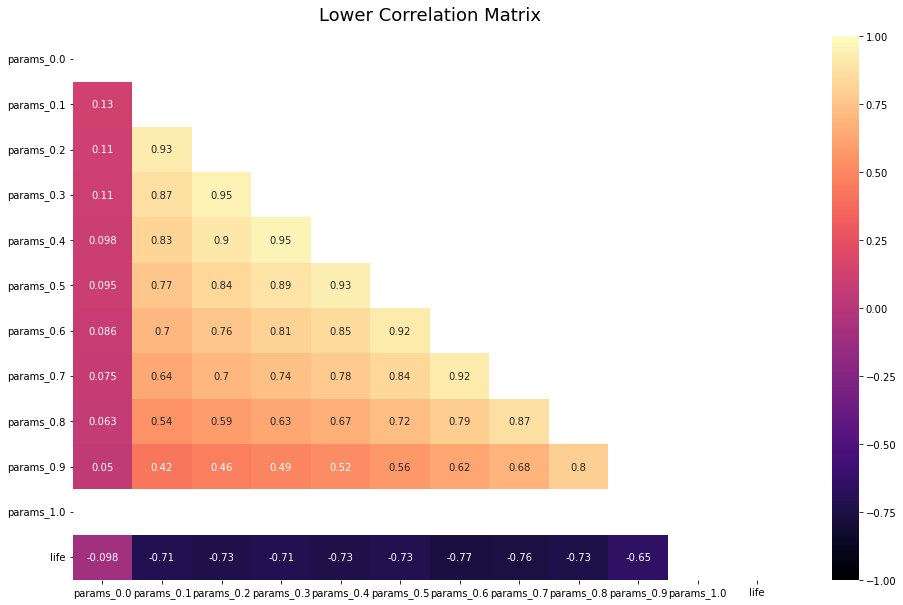

In [33]:
customize_corr(temp[temp.attrition==1].drop('attrition',axis=1)) #use my function to customize correlations

So, let's keep 0. 5  as tresholds(higher correlation between real litetime and the lifetime we've estimated . 
Below this value, we 'll decide that at there is attrition.

In [34]:
#predict and transpose output
temp=cph.predict_survival_function(test.set_index('customer_Id'),conditional_after=test.life).T
#give friendly name to the news columns
temp.columns=['month'+  str(i) for i in range(1,temp.shape[1]+1)]
#wide dataframe to long dataframe
df_long=pd.melt( 
                df_wide, 
                id_vars=['index','life','attrition'], 
                value_vars=temp.columns[temp.columns.str.startswith('month')]
               ).\
               rename(columns={'variable':'month'}
                )
#transform monhs columns to int Ex : month_3 ==> 3
df_long['month']=df_long['month'].str.replace('month','').astype(int)
df_long=df_long.set_index('index')
df_long

,life,attrition,month,value
index,,,,
270281,34,0,1,1.0
270022,29,1,1,1.0
272350,9,1,1,1.0
271029,26,0,1,1.0
270365,16,0,1,1.0
...,...,...,...,...
267408,35,0,38,1.0
272796,36,0,38,1.0
273328,35,0,38,1.0


In [35]:
temp

,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,...,month29,month30,month31,month32,month33,month34,month35,month36,month37,month38
275186,1.0,0.994964,0.990274,0.985334,0.978364,0.970897,0.963318,0.955865,0.946903,0.936694,...,0.888553,0.888553,0.888553,0.888553,0.888553,0.888553,0.888553,0.888553,0.888553,0.888553
272485,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
267180,1.0,0.962354,0.923310,0.885018,0.848628,0.806500,0.760597,0.706966,0.674402,0.641910,...,0.571861,0.571861,0.571861,0.571861,0.571861,0.571861,0.571861,0.571861,0.571861,0.571861
267775,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
271876,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274329,1.0,0.942109,0.896478,0.830324,0.745727,0.682539,0.620283,0.533758,0.466802,0.392147,...,0.007904,0.007904,0.007904,0.007904,0.007904,0.007904,0.007904,0.007904,0.007904,0.007904
271553,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
272101,1.0,0.985866,0.966389,0.950630,0.933895,0.908202,0.885876,0.857667,0.832081,0.805835,...,0.415392,0.415392,0.415392,0.415392,0.415392,0.415392,0.415392,0.415392,0.415392,0.415392
267107,1.0,0.983235,0.968144,0.953462,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094,...,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094,0.945094
